In [1]:
import torch 
from torch import nn

import math
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(111)

# Training Data 

In [3]:
trainig_data_length = 1024
train_data = torch.zeros((trainig_data_length,2))
train_data[:,0] = 2*math.pi*torch.rand(trainig_data_length)
train_data[:,1] = torch.sin(train_data[:,0])
train_labels = torch.zeros(trainig_data_length)
#tensor labels just bcz required by pytorch data loader but not used bcz gans use unsupervised learning techniques
train_set = [
    (train_data[i], train_labels[i]) for i in range(trainig_data_length)
]

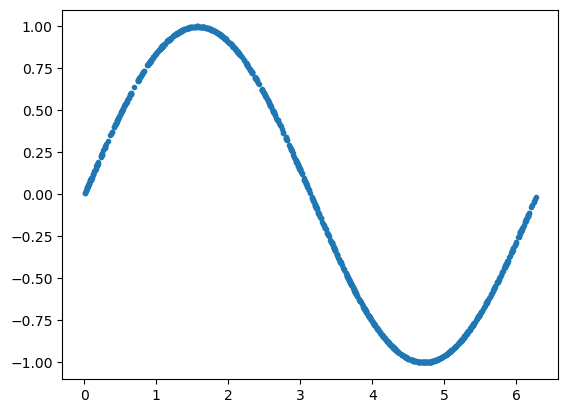

In [4]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [5]:
#Pytorch data loader
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

# Discriminator

In [6]:
#takes as an entry the real/fake data and returns the probability of the input being real
#dim of entry is 2, dim of output is 1
class Discriminator(nn.Module): 
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3), #zeroes 30 percent of the input layer to prevent overfitting
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        output = self.model(x)
        return output


In [7]:
discriminator = Discriminator()

# Generator

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2), # a vector of 2 elements and no activation function so it can range from -inf to inf 
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [9]:
generator = Generator()

# Training the Models

In [10]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

In [11]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [12]:
print(train_loader)

In [13]:
for epoch in range(num_epochs):
    #each batch is a tuple (real_samples, labels) where real_samples is a tensor of batch_size (32) data
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.21308740973472595
Epoch: 0 Loss G.: 1.7989581823349
Epoch: 10 Loss D.: 0.6099680662155151
Epoch: 10 Loss G.: 0.9077385067939758
Epoch: 20 Loss D.: 0.6200631260871887
Epoch: 20 Loss G.: 0.9532093405723572
Epoch: 30 Loss D.: 0.6283484697341919
Epoch: 30 Loss G.: 0.9910151362419128
Epoch: 40 Loss D.: 0.6843723058700562
Epoch: 40 Loss G.: 0.6606213450431824
Epoch: 50 Loss D.: 0.6624276638031006
Epoch: 50 Loss G.: 0.7260463237762451
Epoch: 60 Loss D.: 0.7013164162635803
Epoch: 60 Loss G.: 0.663277268409729
Epoch: 70 Loss D.: 0.6673065423965454
Epoch: 70 Loss G.: 0.7007033228874207
Epoch: 80 Loss D.: 0.6546181440353394
Epoch: 80 Loss G.: 0.7684346437454224
Epoch: 90 Loss D.: 0.7291876077651978
Epoch: 90 Loss G.: 0.6766138076782227
Epoch: 100 Loss D.: 0.6198608875274658
Epoch: 100 Loss G.: 0.8269668817520142
Epoch: 110 Loss D.: 0.6426212787628174
Epoch: 110 Loss G.: 0.7759957909584045
Epoch: 120 Loss D.: 0.6716338992118835
Epoch: 120 Loss G.: 0.7812103629112244
Epoch: 130 

In [14]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)

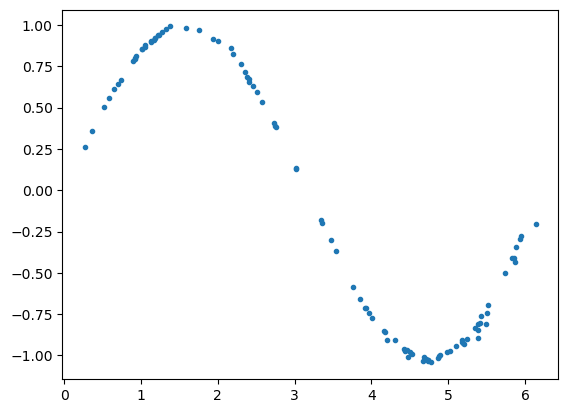

In [15]:
generated_samples = generated_samples.detach()
#since the generator gives a 2 elemts vector and we pass through it 100 elements, the size of generated_samples is 100x2
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")